## Aim
### To predict which organelle the unknown tail anchored proteins localize to by focusing their hydrophobicy and amino acid charge at the tails.

## Preparing dataset

In [1]:
# import packages required
import pandas as pd
import seaborn as sns
import numpy as np
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# import data
# this datadest is a list of proteins whose localizations have been reported. 
# the data also contains the features of protains' tail: hydrophobicity (annotated as GRAVY), and charge.
# the data is obtained from Costello et al., JCS, 2017 (https://journals.biologists.com/jcs/article/130/9/1675/56732/Predicting-the-targeting-of-tail-anchored-proteins)

data = pd.read_excel("/Users/jiang/Desktop/SWBio ML assignment/zebrafish_TA_protein_prediction.xlsx")
print(data.head())

                   Gene                                     Annotated as  \
0     ZDB-GENE-030427-1                                           cntn1a   
1    ZDB-GENE-070705-18                                           acbd5b   
2   ZDB-GENE-040801-131  bokax,Bcl-2-relatedovariankillerproteinhomologA   
3   ZDB-GENE-050522-268                                           acbd5a   
4  ZDB-GENE-040426-1443                                           cdkal1   

                                             Protein  \
0                                       Contactin-1a   
1     Acyl-CoA-binding domain-containing protein 5-B   
2     Bcl-2-related ovarian killer protein homolog A   
3      Acyl-CoA-binding domain-containing protein 5A   
4  Threonylcarbamoyladenosine tRNA methylthiotran...   

  Possible organelle prediction (not using classifier)  Length  Exp AA  \
0                             PM(hasERsignalpeptide)      1032    4.44   
1                                                PO!      

In [3]:
# make a new dataframe that only contains specific rows
data_1 = data.filter(["Annotated as", "TMD", "GRAVY", "Tail charge"], axis=1)
data_1.head()

,Annotated as,TMD,GRAVY,Tail charge
0,cntn1a,GLVGMAIVGGIGLGVAGLAGLI,NaN,NaN
1,acbd5b,SPFTAVLTVLWPFAVHWLVQFYL,1.252,4.9
2,"bokax,Bcl-2-relatedovariankillerproteinhomologA",WLVTAACACGHYLKAVVFYLL,1.481,0.9
3,acbd5a,WWPFDVSLGTVAFAVVWPFVV,1.414,5.9
4,cdkal1,ILAVVLLLSAVLLALLMEKLL,2.581,//


In [4]:
# remove rows with NaN
data_2 = data_1.dropna(axis = 0, how = "any")
print(data_2)

                                        Annotated as                      TMD  \
1                                             acbd5b  SPFTAVLTVLWPFAVHWLVQFYL   
2    bokax,Bcl-2-relatedovariankillerproteinhomologA    WLVTAACACGHYLKAVVFYLL   
3                                             acbd5a    WWPFDVSLGTVAFAVVWPFVV   
4                                             cdkal1    ILAVVLLLSAVLLALLMEKLL   
5                                           ankrd46b    VLLLLVVIALLSLGIAYYVSG   
..                                               ...                      ...   
649                                           rnf152   AWTGVCTVLLVAFILIFLLGIV   
650                                            lrch4   SIGFLLFYSLLMALLYLLYCNL   
651                                     LOC101885013   AAVSSPAAWVGVGIGVCAAYAY   
652                                             lmln   VVNLWQLLLTLTPLLIGFLLCG   
653                                            caln1   SLICAFAMAFIISVMLIAANQM   

        GRAVY Tail charge  

Row 4 has "//" instead of NaN, which was not removed by .dropna() function

In [5]:
# used drop() function to remove the row with "//"
data_3 = data_2.drop(data_2[data_2["Tail charge"] == "//"].index)
print(data_3)

                                        Annotated as                      TMD  \
1                                             acbd5b  SPFTAVLTVLWPFAVHWLVQFYL   
2    bokax,Bcl-2-relatedovariankillerproteinhomologA    WLVTAACACGHYLKAVVFYLL   
3                                             acbd5a    WWPFDVSLGTVAFAVVWPFVV   
5                                           ankrd46b    VLLLLVVIALLSLGIAYYVSG   
6                                              stx18    AGFRVWILFFLVMCSFSLLFL   
..                                               ...                      ...   
649                                           rnf152   AWTGVCTVLLVAFILIFLLGIV   
650                                            lrch4   SIGFLLFYSLLMALLYLLYCNL   
651                                     LOC101885013   AAVSSPAAWVGVGIGVCAAYAY   
652                                             lmln   VVNLWQLLLTLTPLLIGFLLCG   
653                                            caln1   SLICAFAMAFIISVMLIAANQM   

        GRAVY Tail charge  

<Axes: xlabel='GRAVY', ylabel='Tail charge'>

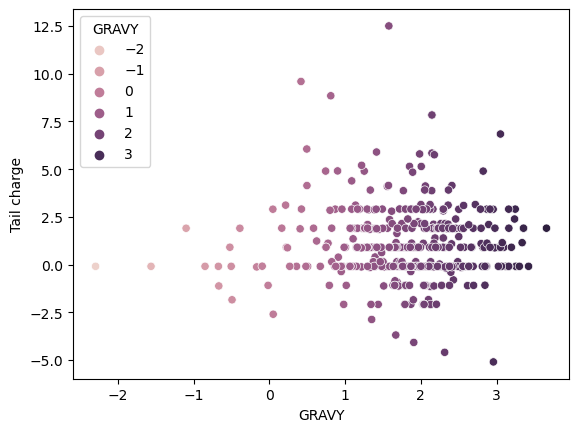

In [6]:
# plot the data
sns.scatterplot(data=data_3, x="GRAVY", y="Tail charge", hue="GRAVY")

In [7]:
# import dataset that will be used as teacher dataset
data_teacher = pd.read_excel("/Users/jiang/Desktop/SWBio ML assignment/data_teacher_human.xlsx")
print(data_teacher.head())

  Location   Name                 Unnamed: 2  Isoforms       Accession  \
0     MITO   MAOA        monoamine oxidase A  isoform1     NP_000231.1   
1     MITO   MAOA                        NaN  isoform2  NP_001257387.1   
2     MITO   MAOB        monoamine oxidase B         -     NP_000889.3   
3     MITO  CYB5B       cytochrome b5 type B         -     NP_085056.2   
4     MITO    BAX  BCL2-associated X protein      zeta  NP_001278360.1   

   Size (aa)  Tail (aa)      TMD  TMD length               TMD sequence  ...  \
0        527          8  504-519          16         IIGFSTSVTALGFVLY    ...   
1        394          8  371-386          16                        NaN  ...   
2        520          8  490-512          23    PGLLRLIGLTTIFSATALGFLAH  ...   
3        150          6  122-144          23  CWAYWILPIIGAVLLGFLYRYYT    ...   
4        114          4   88-110          23    GTPTWQTVTIFVAGVLTASLTIW  ...   

   GRAVY Tail charge       -10 AA  GRAVY.1 Charge                 -20 AA  

In [8]:
# make a new teacher dataframe that only contains specific columns
data_teacher = data_teacher.filter(["Location", "Name", "GRAVY", "Tail charge"], axis=1)
data_teacher.head()

,Location,Name,GRAVY,Tail charge
0,MITO,MAOA,1.706,2.9
1,MITO,MAOA,NaN,NaN
2,MITO,MAOB,1.278,2.9
3,MITO,CYB5B,1.183,-0.1
4,MITO,BAX,0.996,1.9


In [9]:
# remove rows with NaN
data_teacher_2 = data_teacher.dropna(axis = 0, how = "any")
print(data_teacher_2)


      Location      Name  GRAVY  Tail charge
0         MITO      MAOA  1.706          2.9
2         MITO      MAOB  1.278          2.9
3         MITO     CYB5B  1.183         -0.1
4         MITO       BAX  0.996          1.9
5         MITO       BAX  1.450          1.9
6         MITO       BAX  1.280          1.9
8         MITO      MTX1  2.143         -3.1
10        MITO     TOMM5  1.578          0.9
11        MITO     TOMM6  1.211         -2.1
12        MITO     TOMM7  1.650         -0.1
13        MITO    TOMM22  2.067         -0.1
14        MITO      BAK1  1.991          2.9
15        MITO      MCL1  1.622          0.9
17        MITO   BCL2L13  2.657          2.9
22        MITO   BCL2L10  1.750          0.9
23        MITO    BCL2L2  1.670          0.9
24        MITO       HRK  1.152          1.9
25        MITO   GDAP1L1  0.904          2.9
30          PO     ACBD5  1.226          4.9
35          PO     PEX26  1.906          5.2
36          PO  FALDH-PO  2.483          9.1
37        

/Users/jiang/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


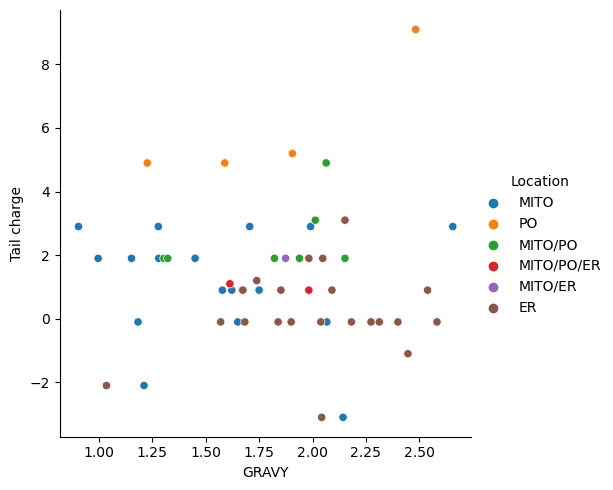

In [10]:
# plot the data

sns.relplot(
    data=data_teacher_2,
    x="GRAVY",
    y="Tail charge",
    hue="Location",
)

## To classify data using K-nearest neighbours



In [11]:
# define parameter used for Nearest neighbours
X = data_teacher_2[["GRAVY", "Tail charge"]]
y = data_teacher_2["Location"]

In [12]:
# Use scikit-learn to split data into a subset of data to fit with and a subset of data to test against
train_X, test_X, train_y, test_y = train_test_split(X, y)

In [13]:
# define the model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X, train_y)

KNeighborsClassifier()

In [14]:
# test the model
model.score(test_X, test_y)

0.21428571428571427

<Axes: xlabel='GRAVY', ylabel='Tail charge'>

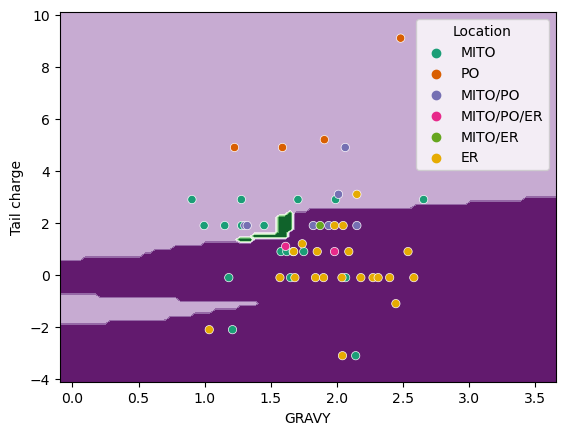

In [15]:
# to plot the predictions of the model

DecisionBoundaryDisplay.from_estimator(model, X, cmap="PRGn")
sns.scatterplot(data=X, x="GRAVY", y="Tail charge", hue=y, palette="Dark2")

In [16]:
# remove proteins that localize to multiple organelles

data_teacher_3 = data_teacher_2[(data_teacher_2["Location"] == "MITO") | (data_teacher_2["Location"] == "PO") | (data_teacher_2["Location"] == "ER")]
data_teacher_3

,Location,Name,GRAVY,Tail charge
0,MITO,MAOA,1.706,2.9
2,MITO,MAOB,1.278,2.9
3,MITO,CYB5B,1.183,-0.1
4,MITO,BAX,0.996,1.9
5,MITO,BAX,1.450,1.9
6,MITO,BAX,1.280,1.9
8,MITO,MTX1,2.143,-3.1
10,MITO,TOMM5,1.578,0.9
11,MITO,TOMM6,1.211,-2.1
12,MITO,TOMM7,1.650,-0.1


In [17]:
# define parameter used for Nearest neighbours

X2 = data_teacher_3[["GRAVY", "Tail charge"]]
y2 = data_teacher_3["Location"]

In [18]:
# split data into a training data set and a test data set
train_X2, test_X2, train_y2, test_y2 = train_test_split(X2, y2)

In [19]:
# define model
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(train_X2, train_y2)

KNeighborsClassifier()

In [20]:
# test the model
model2.score(test_X2, test_y2)

0.5454545454545454

the score is not good... but still move on

<Axes: xlabel='GRAVY', ylabel='Tail charge'>

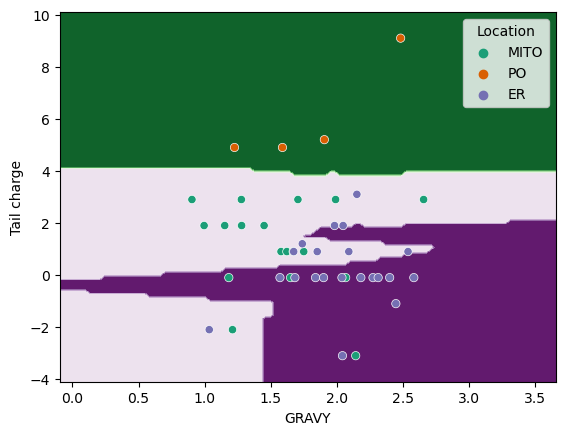

In [21]:
# to plot the predictions of the model

DecisionBoundaryDisplay.from_estimator(model2, X, cmap="PRGn")
sns.scatterplot(data=X2, x="GRAVY", y="Tail charge", hue=y2, palette="Dark2")

In [22]:
# import list of predicted-proteins whose localization is not known
pred = pd.read_excel("/Users/jiang/Desktop/SWBio ML assignment/zebrafish_TA_protein_prediction.xlsx")
print()

In [23]:
# filter the data
pred_1 = pred.filter(["Annotated as", "TMD", "GRAVY", "Tail charge"], axis=1)
pred_1.head()

,Annotated as,TMD,GRAVY,Tail charge
0,cntn1a,GLVGMAIVGGIGLGVAGLAGLI,NaN,NaN
1,acbd5b,SPFTAVLTVLWPFAVHWLVQFYL,1.252,4.9
2,"bokax,Bcl-2-relatedovariankillerproteinhomologA",WLVTAACACGHYLKAVVFYLL,1.481,0.9
3,acbd5a,WWPFDVSLGTVAFAVVWPFVV,1.414,5.9
4,cdkal1,ILAVVLLLSAVLLALLMEKLL,2.581,//


In [24]:
# remove row with NaN
pred_2 = pred_1.dropna(axis = 0, how = "any")
print(pred_2)

                                        Annotated as                      TMD  \
1                                             acbd5b  SPFTAVLTVLWPFAVHWLVQFYL   
2    bokax,Bcl-2-relatedovariankillerproteinhomologA    WLVTAACACGHYLKAVVFYLL   
3                                             acbd5a    WWPFDVSLGTVAFAVVWPFVV   
4                                             cdkal1    ILAVVLLLSAVLLALLMEKLL   
5                                           ankrd46b    VLLLLVVIALLSLGIAYYVSG   
..                                               ...                      ...   
649                                           rnf152   AWTGVCTVLLVAFILIFLLGIV   
650                                            lrch4   SIGFLLFYSLLMALLYLLYCNL   
651                                     LOC101885013   AAVSSPAAWVGVGIGVCAAYAY   
652                                             lmln   VVNLWQLLLTLTPLLIGFLLCG   
653                                            caln1   SLICAFAMAFIISVMLIAANQM   

        GRAVY Tail charge  

In [25]:
# same as the teacher data, remove the column with "//", whcih means NaN

pred_3 = pred_2.drop(pred_2[pred_2["Tail charge"] == "//"].index)
print(pred_3)

                                        Annotated as                      TMD  \
1                                             acbd5b  SPFTAVLTVLWPFAVHWLVQFYL   
2    bokax,Bcl-2-relatedovariankillerproteinhomologA    WLVTAACACGHYLKAVVFYLL   
3                                             acbd5a    WWPFDVSLGTVAFAVVWPFVV   
5                                           ankrd46b    VLLLLVVIALLSLGIAYYVSG   
6                                              stx18    AGFRVWILFFLVMCSFSLLFL   
..                                               ...                      ...   
649                                           rnf152   AWTGVCTVLLVAFILIFLLGIV   
650                                            lrch4   SIGFLLFYSLLMALLYLLYCNL   
651                                     LOC101885013   AAVSSPAAWVGVGIGVCAAYAY   
652                                             lmln   VVNLWQLLLTLTPLLIGFLLCG   
653                                            caln1   SLICAFAMAFIISVMLIAANQM   

        GRAVY Tail charge  

#### The following cell can be skipped when assessed

In [26]:
# save the dataframe as excel file
# pred_3.to_excel('/Users/jiang/Desktop/SWBio ML assignment/prediction_protein list.xlsx')

In [27]:
# create new dataframe that only contains specific columns
pred_4 = pred_3[["GRAVY", "Tail charge"]]

In [28]:
pred_4["Location"] = model2.predict(pred_4)  
pred_4

/var/folders/jr/s08dyk3n2dzbbsypszr02wxc0000gn/T/ipykernel_19472/2347378118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_4["Location"] = model2.predict(pred_4)


,GRAVY,Tail charge,Location
1,1.252000,4.9,PO
2,1.481000,0.9,MITO
3,1.414000,5.9,PO
5,2.429000,-0.8,ER
6,2.129000,-2.1,ER
...,...,...,...
649,2.631818,2.087354,MITO
650,1.868182,-0.09,ER
651,1.295455,1.90998,MITO
652,1.850000,-1.087494,ER


#### The following cell can be skipped when assessed

In [29]:
# save the data as an excel file
pred_4.to_excel('/Users/jiang/Desktop/SWBio ML assignment/prediction_result.xlsx')

/Users/jiang/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


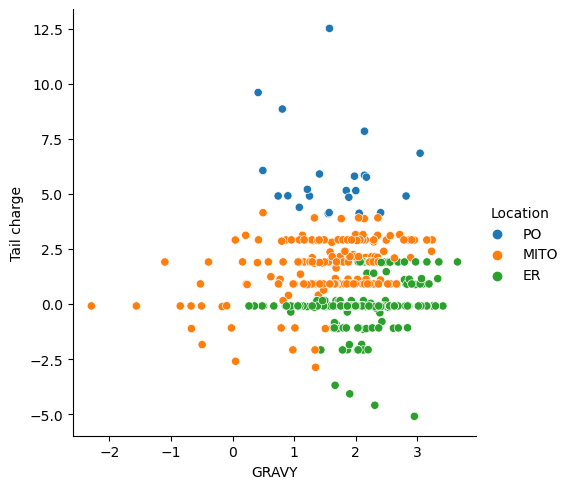

In [30]:
#plot the result of prediction

sns.relplot(
    data=pred_4,
    x="GRAVY",
    y="Tail charge",
    hue="Location",
)